# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [291]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import collections

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [292]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [293]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [294]:
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [295]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info_cl = feat_info.copy()
for index in feat_info_cl.index:
    feat_info_cl.loc[index,'missing_or_unknown'] = feat_info_cl.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info_cl.loc[index,'missing_or_unknown'])):
        try:
            feat_info_cl.loc[index,'missing_or_unknown'][item] = int(feat_info_cl.loc[index,'missing_or_unknown'][item])
        except:
            continue
    azdias.loc[:,(feat_info_cl.loc[index, 'attribute'])].replace(feat_info_cl.loc[index,'missing_or_unknown'], np.nan, inplace=True)

In [296]:
# Sanity check
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [297]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias_nan = azdias.isnull().sum()

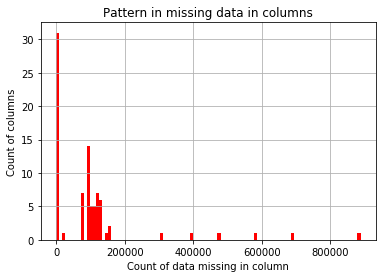

In [298]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(azdias_nan, bins=100, color ='r')
plt.xlabel('Count of data missing in column')
plt.ylabel('Count of columns')
plt.title('Pattern in missing data in columns')
plt.grid()
plt.show()

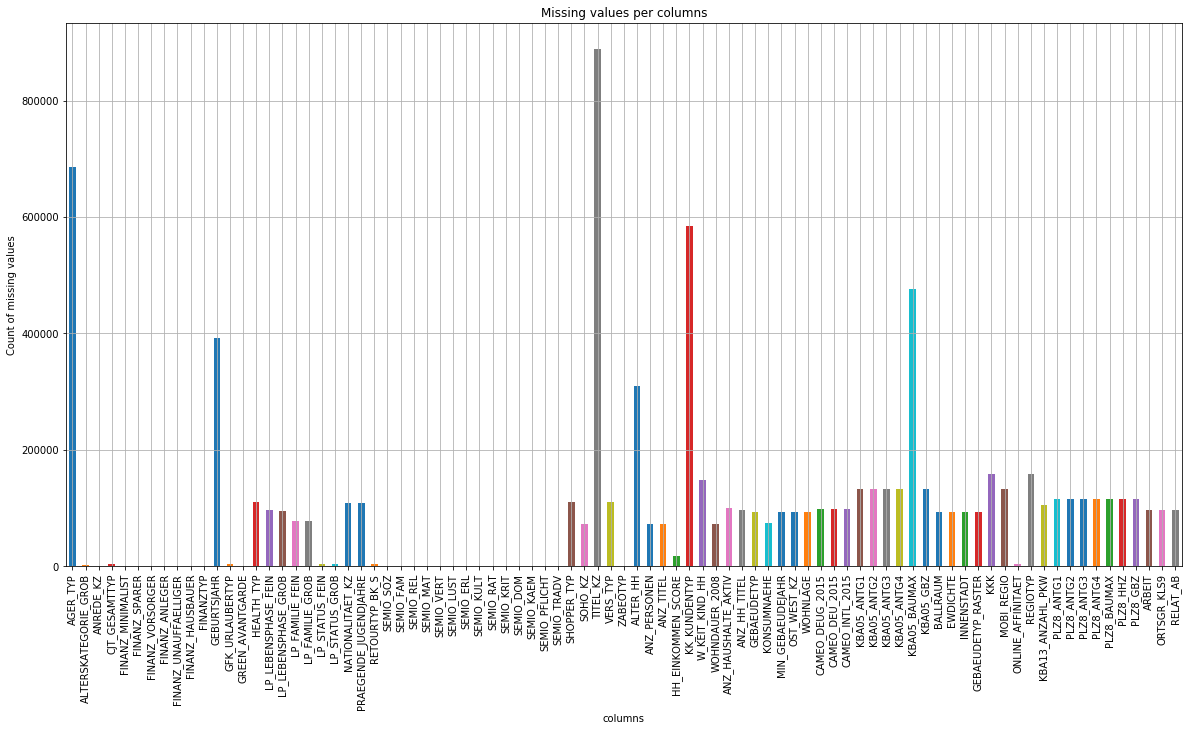

In [299]:
# Closer look at missing values per columns

azdias_nan.plot.bar(figsize=(20,10))
plt.xlabel('columns')
plt.ylabel('Count of missing values')
plt.title('Missing values per columns')
plt.grid()
plt.show()

In [300]:
# Percentage of data that have more than 200 000 missing values (outliers):
pct_outliers = len(azdias_nan[azdias_nan>200000])/ len(azdias.columns) * 100

#Percentage of data that have very few missing values:
pct_fine = len(azdias_nan[azdias_nan<5])/ len(azdias.columns) * 100

#Percentage of data that have between 6 and 200 000 missing values:
pct_other = (len(azdias_nan[azdias_nan<200000]) - len(azdias_nan[azdias_nan<5]))/ len(azdias.columns) * 100

print('Porportion of outlier columns in Dataset: {}%'.format(pct_outliers))
print('Porportion of clean columns in Dataset: {}%'.format(pct_fine))
print('Porportion of other columns in Dataset: {}%'.format(pct_other))

Porportion of outlier columns in Dataset: 7.0588235294117645%
Porportion of clean columns in Dataset: 28.235294117647058%
Porportion of other columns in Dataset: 64.70588235294117%


In [301]:
# Identify the outliers

outliers = azdias_nan[azdias_nan>200000]
print(outliers)

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64


In [302]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(labels=outliers.index, axis=1, inplace = True)


In [303]:
# Sanity check
print(azdias.shape)
azdias.head()

(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column


We can see from the distribution of missing values that approximately 28% of the columns have no or a very small number of missing data (less than 5 missing values). Most of the columns (approximately 65% of the columns) have between 5 and 200 000 missing data, with most of the columns having around 100 000 missing data.

Some columns have a lot of missing data and seem to be outliers, comparing to the rest of the columns. I have considered that every column having more than 200 000 missing values is an outlier. I have identified those columns and removed them from the dataset. 
Following 6 columns were thus removed from the dataset: 

'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [304]:
# How much data is missing in each row of the dataset?

azdias_nan_row = azdias.isnull().sum(axis=1)

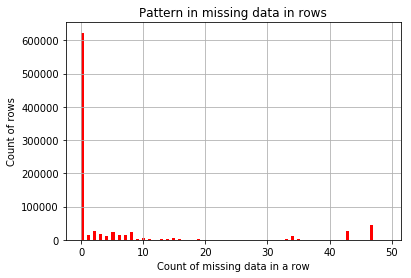

In [305]:
# Plot the distribution of missing valuesin rows

plt.hist(azdias_nan_row, bins=100, color = 'r')
plt.xlabel('Count of missing data in a row')
plt.ylabel('Count of rows')
plt.title('Pattern in missing data in rows')
plt.grid()
plt.show()

In [306]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# I decide to separate the rows, considering outliers rows missing 10 or more values.
azdias_f = azdias.drop(azdias[azdias_nan_row>10].index)
outlier_rows = azdias.drop(azdias[azdias_nan_row<=10].index)
number_of_outlier_rows = len(outlier_rows)

print(azdias_f.shape)
print(outlier_rows.shape)

(780153, 79)
(111068, 79)


In [307]:
# Identify 5 columns with no missing data 
fine_columns = []
for column in azdias.columns:
    if azdias_f[column].isnull().sum() == 0 and outlier_rows[column].isnull().sum() == 0:
        fine_columns.append(column)
        
fine_columns = fine_columns[0:5]
fine_columns

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER']

In [308]:
# Define a function to plot a comparison of column code frequencies between fine rows and outlier rows.

def compare_column(column_name):
    figure, axs = plt.subplots(nrows=1, ncols=2)#, figsize = (15,20))
    figure.subplots_adjust(hspace = 1, wspace=4)
    
    sns.countplot(azdias_f[column_name], ax=axs[0])
    axs[0].set_title('Rows with little missing data')
    sns.countplot(outlier_rows[column_name], ax=axs[1])
    axs[1].set_title('Rows with many missing values')
    figure.suptitle(column_name)

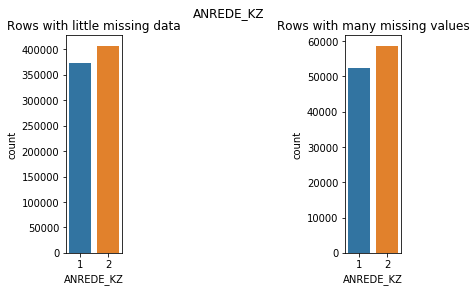

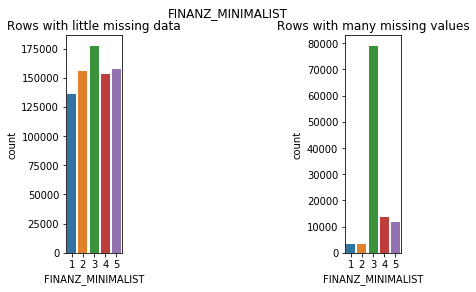

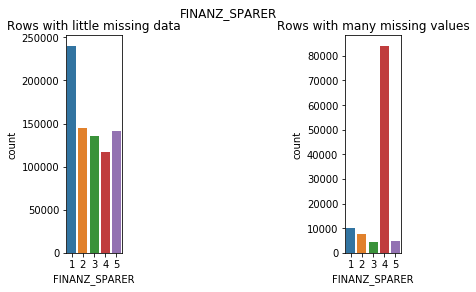

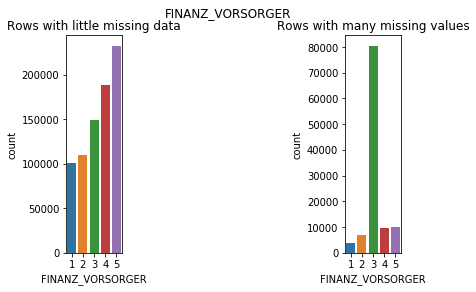

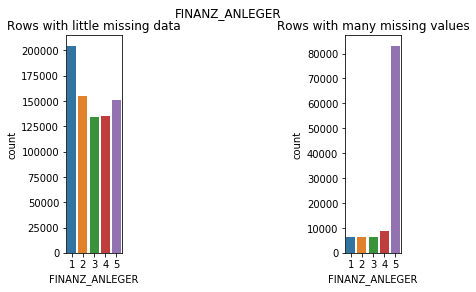

In [309]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

for column in fine_columns:
    compare_column(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row


We can see from the comparison plots accross columns wit no missing vakues above that the outlier rows with many missing values do have a different distribution compared to rows with little missing data. While the column 'ANREDE_KZ' has similiar distribution of values for both types of rows, the other plotted columns show large differences between both types of rows.
Thus it is not straightforward to drop the outlier rows from the dataset. I will drop them know but take their number into account at the end of the project.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [310]:
# Filter out the drop columns in 1.1

features = azdias_f.columns
clean_feat_info = feat_info[feat_info['attribute'].isin(features)]
clean_feat_info.head(15)

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [311]:
# How many features are there of each data type?

grouped_feat =clean_feat_info.groupby('type')
for name, group in grouped_feat:
    print('{} feature(s) of type {}.'.format(group.count()['type'], name))

18 feature(s) of type categorical.
6 feature(s) of type mixed.
6 feature(s) of type numeric.
49 feature(s) of type ordinal.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [312]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categ_feat = clean_feat_info[clean_feat_info['type']=='categorical']['attribute']
#categ_feat

# group binary categorical features and multi-level categorical features.
binary_categ_feat = []
multi_categ_feat = []

for feat in categ_feat:
    possible_cat = azdias_f[feat].dropna().unique()
    if len(possible_cat)==2:
        binary_categ_feat.append(feat)
    elif len(possible_cat)>2:
        multi_categ_feat.append(feat)
        
print('Binary categorical features: {}'.format(binary_categ_feat))
print('Mulit-level categorical features: {}'.format(multi_categ_feat))

Binary categorical features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Mulit-level categorical features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [313]:
for feat in binary_categ_feat:
    possible_cat = azdias_f[feat].unique()
    print('Possible categories for {}: {}'.format(feat, possible_cat))

Possible categories for ANREDE_KZ: [2 1]
Possible categories for GREEN_AVANTGARDE: [0 1]
Possible categories for SOHO_KZ: [ 1.  0.]
Possible categories for VERS_TYP: [  2.   1.  nan]
Possible categories for OST_WEST_KZ: ['W' 'O']


In [314]:
# Re-encode categorical variable(s) to be kept in the analysis.

new_cat = {'W': 0, 'O':1}
replacement = {'OST_WEST_KZ': new_cat}
azdias_fc = azdias_f.replace(replacement)


In [315]:
# We choose to drop all the multi-level categorical features:

for feat in multi_categ_feat:
    azdias_fc = azdias_fc.drop(feat, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- I identified all categorical features, differentiated bewteen binary categories and multi-level categories.
- I dropped the multi-level categorical features from the dataset for simplicity.
- Among the binary categorical features, OST_WEST_KZ was none numerical. For this we encoded the non.numerical values with dummy numerical values 0 and 1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [316]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print(azdias_fc['PRAEGENDE_JUGENDJAHRE'].unique())
# Further, I took a look at Data_Dictionnary.md to get the all the possible values and their meaning.
replacement_decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
replacement_movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

[ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]


In [317]:
# Create two new features that capture the decade and the movement in which individuals grew up.
azdias_fc['DECADE']= azdias_fc['PRAEGENDE_JUGENDJAHRE']
azdias_fc['DECADE'].replace(replacement_decade, inplace=True)

azdias_fc['MOVEMENT'] = azdias_fc['PRAEGENDE_JUGENDJAHRE']
azdias_fc['MOVEMENT'].replace(replacement_movement, inplace=True)

In [318]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_fc['CAMEO_INTL_2015'].unique()
# Further, I took a look at Data_Dictionnary.md to get the all the possible values and their meaning.
replacement_wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
replacement_life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

In [319]:
# Create to new features to that capture the wealth status and life stage of indivuals.
azdias_fc['WEALTH'] = azdias_fc['CAMEO_INTL_2015']
azdias_fc['WEALTH'].replace(replacement_wealth, inplace=True)

azdias_fc['LIFE_STAGE'] = azdias_fc['CAMEO_INTL_2015']
azdias_fc['LIFE_STAGE'].replace(replacement_life_stage, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- In this part I processed the mixed-value features 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'.
- Out of each feature I engineered 2 new features with values that respectively map the meaning (Decade and Movement of individuals' youth, Wealth status and Life stage of individuals) of the original features. (I used Data_Dictionnary.md for this.) 
- I decide to drop all the mixed-values features from the dataset, for simplicity.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [320]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [321]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

mixed_feat = clean_feat_info[clean_feat_info['type']=='mixed']['attribute']
for feat in mixed_feat:
    azdias_fc.drop(feat, axis=1, inplace=True)

In [322]:
print(azdias_fc.shape)
azdias_fc.head()

(780153, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [323]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
   
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info_cl = feat_info.copy()
    for index in feat_info.index:
        feat_info_cl.loc[index,'missing_or_unknown'] = feat_info_cl.loc[index,'missing_or_unknown'].strip('[]').split(',')    
        for item in range(len(feat_info_cl.loc[index,'missing_or_unknown'])):
            try:
                feat_info_cl.loc[index,'missing_or_unknown'][item] = int(feat_info_cl.loc[index,'missing_or_unknown'][item])
            except:
                continue
        df.loc[:,(feat_info_cl.loc[index, 'attribute'])].replace(feat_info_cl.loc[index,'missing_or_unknown'], np.nan, inplace=True)
    
    
    # remove selected columns and rows, ...
    outliers = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    for feat in outliers:
        df.drop(feat, axis=1, inplace = True)
    
    df_nan_row = df.isnull().sum(axis=1)
    
    ######################
    plt.hist(df_nan_row, bins=100, color = 'r')
    plt.xlabel('Count of missing data in a row')
    plt.ylabel('Count of rows')
    plt.title('Pattern in missing data in rows')
    plt.grid()
    plt.show()
    ######################
    
    
    df_filtered = df.drop(df[df_nan_row>10].index)
    df_filtered
    features = df_filtered.columns
    clean_feat_info = feat_info[feat_info['attribute'].isin(features)]
    
    
    # select, re-encode, and engineer column values.
    # Binary Categ
    new_cat = {'W': 0, 'O':1}
    replacement = {'OST_WEST_KZ': new_cat}
    df_filtered_cleaned = df_filtered.replace(replacement)
    
    # Multi-level categ
    multi_categ_feat = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    for feat in multi_categ_feat:
        df_filtered_cleaned.drop(feat, axis=1, inplace=True)

        
    # Mixed features
    replacement_decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    replacement_movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df_filtered_cleaned['DECADE']= df_filtered_cleaned['PRAEGENDE_JUGENDJAHRE']
    df_filtered_cleaned['DECADE'].replace(replacement_decade, inplace=True)
    df_filtered_cleaned['MOVEMENT'] = df_filtered_cleaned['PRAEGENDE_JUGENDJAHRE']
    df_filtered_cleaned['MOVEMENT'].replace(replacement_movement, inplace=True)
    
    replacement_wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
    replacement_life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
    df_filtered_cleaned['WEALTH'] = df_filtered_cleaned['CAMEO_INTL_2015']
    df_filtered_cleaned['WEALTH'].replace(replacement_wealth, inplace=True)
    df_filtered_cleaned['LIFE_STAGE'] = df_filtered_cleaned['CAMEO_INTL_2015']
    df_filtered_cleaned['LIFE_STAGE'].replace(replacement_life_stage, inplace=True)
    
    mixed_feat = clean_feat_info[clean_feat_info['type']=='mixed']['attribute']
    for feat in mixed_feat:
        df_filtered_cleaned.drop(feat, axis=1, inplace=True)
    
    
    # Return the cleaned dataframe.
    return df_filtered_cleaned
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [324]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# To input the missing values within each column (axis=0) are using the 'most_frequent' (mode) stategy as the mode is less sensitive
# to outlier values than the mean oder median.
imputer = Imputer(strategy='most_frequent')
clean = imputer.fit_transform(azdias_fc)
azdias_clean = pd.DataFrame(clean, columns = azdias_fc.columns)

print(azdias_clean.shape)
azdias_clean.head()

(780153, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [325]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaled = scaler.fit_transform(azdias_clean)
azdias_proc = pd.DataFrame(scaled, columns = azdias_clean.columns)

### Discussion 2.1: Apply Feature Scaling


- I applied an imputer on the dataset. For this I chose the "most_frequent" (aka mode) strategy as the mode within each columns is less affected by outlier values than for example the mean or median value.
- I standardized the values within each column by using a StandardScaler instance on the dataset.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [326]:
# Apply PCA to the data.

pca = PCA()
pca.fit(azdias_proc)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

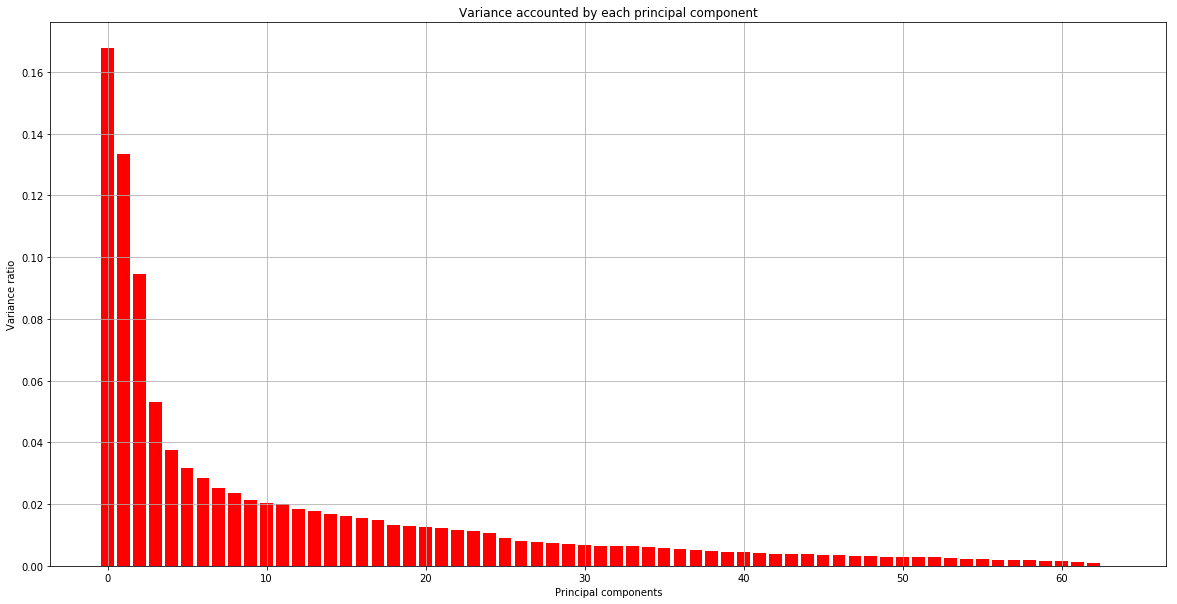

In [327]:
# Investigate the variance accounted for by each principal component.

count_pc = len(pca.components_)
pcs = range(count_pc)
variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize = (20,10))
plt.bar(pcs, variance_ratio, color='r')
plt.xlabel('Principal components')
plt.ylabel('Variance ratio')
plt.title('Variance accounted by each principal component')
plt.grid()
plt.show()

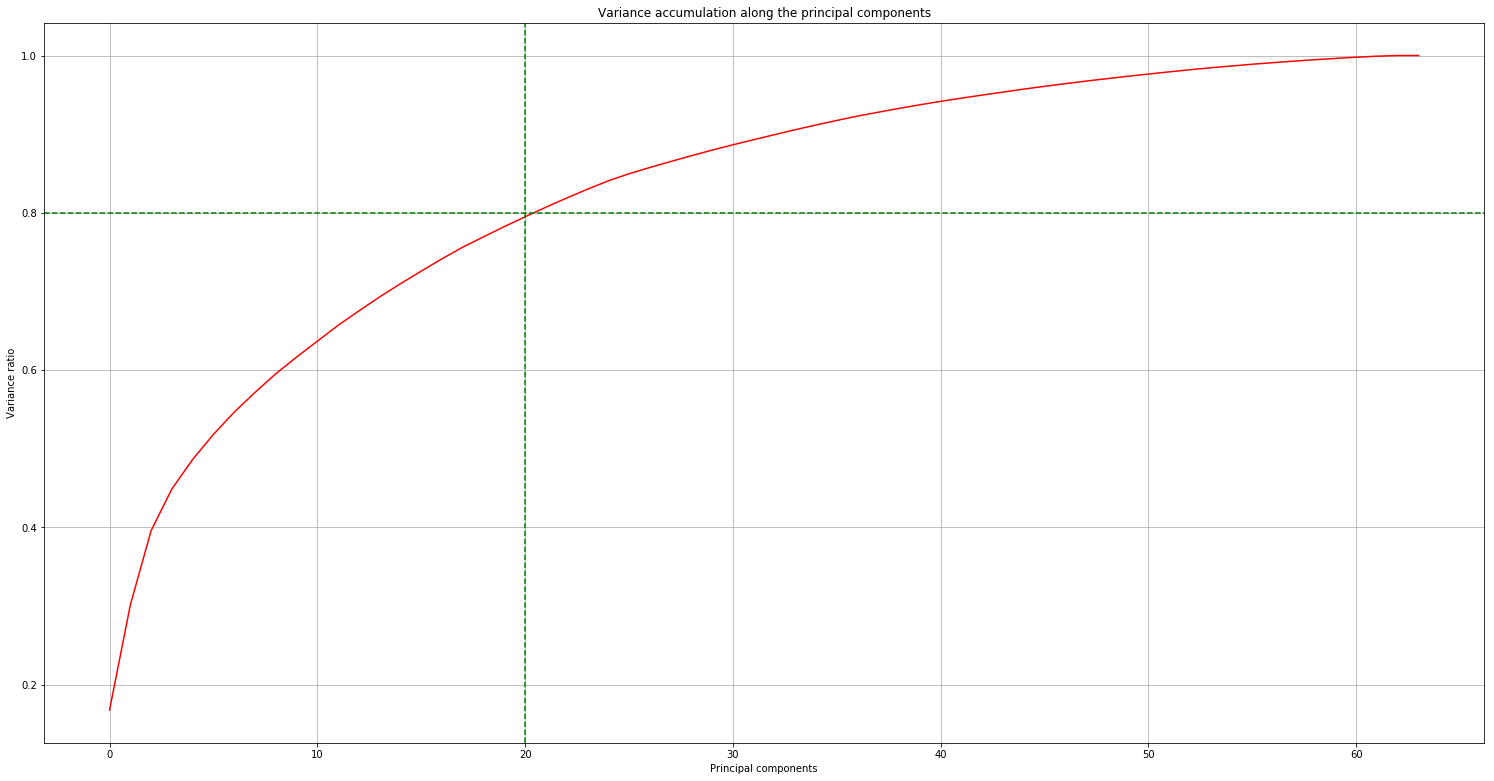

In [328]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_axes([0,0,1,1],True)
ax.plot(np.cumsum(variance_ratio), label='Cumulative Variance',color = 'r')
ax.set_title('Variance accumulation along the principal components')

ax.axvline(20, linestyle='dashed', color='green')
ax.axhline(0.8, linestyle='dashed', color='green')
plt.xlabel('Principal components')
plt.ylabel('Variance ratio')
plt.grid()
plt.show()

In [329]:
print("The 20 first principal components account for exactly {}% of the total variance.".format(np.cumsum(variance_ratio)[20]))

The 20 first principal components account for exactly 0.7949589267050018% of the total variance.


In [330]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_n20 = PCA(n_components=20)
azdias_n20 = pca_n20.fit_transform(azdias_proc)

### Discussion 2.2: Perform Dimensionality Reduction


- By applying pca on the whole dataset, I was able to see the contribution to the variance of each principal component computed by the pca instance.
- A look at the cumulative distribution of the variance along the principal components highlighted that approximatively 80% of the variance is accounted for by the 20 first principal components, i.e. less than one third of the number of features.
- I chose to apply pca with 20 components to the dataset.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [331]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(pca, component):
    pca_components = pd.DataFrame(pca.components_, columns = azdias_proc.columns)
    weights_component = pca_components.iloc[component-1]
    weights_component = weights_component.sort_values(ascending=False)
    # Look at the 20 most interesting features (10 highest positive weights and 10 lowest negative weights)
    return weights_component[:10] , weights_component[-10:]

In [332]:
print(map_weights(pca_n20, 1))

(PLZ8_ANTG3            0.225521
PLZ8_ANTG4            0.217652
WEALTH                0.205360
HH_EINKOMMEN_SCORE    0.203003
ORTSGR_KLS9           0.196412
EWDICHTE              0.194332
FINANZ_HAUSBAUER      0.160922
KBA05_ANTG4           0.153780
PLZ8_ANTG2            0.153533
FINANZ_SPARER         0.151069
Name: 0, dtype: float64, LIFE_STAGE          -0.125117
BALLRAUM            -0.126822
INNENSTADT          -0.164138
PLZ8_GBZ            -0.166674
KONSUMNAEHE         -0.167257
KBA05_GBZ           -0.215960
KBA05_ANTG1         -0.217099
FINANZ_MINIMALIST   -0.221909
PLZ8_ANTG1          -0.225489
MOBI_REGIO          -0.229277
Name: 0, dtype: float64)


In [333]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(map_weights(pca_n20, 2))

(ALTERSKATEGORIE_GROB    0.257347
SEMIO_ERL               0.230371
FINANZ_VORSORGER        0.229879
SEMIO_LUST              0.179988
RETOURTYP_BK_S          0.162667
FINANZ_HAUSBAUER        0.118861
SEMIO_KRIT              0.118787
SEMIO_KAEM              0.115339
W_KEIT_KIND_HH          0.113698
PLZ8_ANTG3              0.098404
Name: 1, dtype: float64, SEMIO_RAT               -0.168269
SEMIO_FAM               -0.183979
FINANZ_ANLEGER          -0.203775
SEMIO_KULT              -0.220872
FINANZ_UNAUFFAELLIGER   -0.225443
SEMIO_PFLICHT           -0.227685
SEMIO_TRADV             -0.229043
FINANZ_SPARER           -0.232629
DECADE                  -0.239653
SEMIO_REL               -0.255200
Name: 1, dtype: float64)


In [334]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(map_weights(pca_n20, 3))

(SEMIO_VERT              0.345928
SEMIO_SOZ               0.262944
SEMIO_FAM               0.249041
SEMIO_KULT              0.232899
FINANZ_MINIMALIST       0.155369
RETOURTYP_BK_S          0.109357
FINANZ_VORSORGER        0.101027
W_KEIT_KIND_HH          0.084941
ALTERSKATEGORIE_GROB    0.079499
SEMIO_REL               0.068448
Name: 2, dtype: float64, FINANZ_UNAUFFAELLIGER   -0.100026
FINANZ_SPARER           -0.106524
DECADE                  -0.111071
SEMIO_ERL               -0.174348
FINANZ_ANLEGER          -0.190645
SEMIO_RAT               -0.217384
SEMIO_KRIT              -0.273430
SEMIO_DOM               -0.312988
SEMIO_KAEM              -0.335855
ANREDE_KZ               -0.367914
Name: 2, dtype: float64)


### Discussion 2.3: Interpret Principal Components


- Looking at the most important features of the first principal component allows the most meaningful interpretation of the features correlation.
- We can see that when a region (macro-cell) has a high number of homes with numerous families inside, it tends to be poorer. PLZ8_ANTG3 and PLZ8_ANTG4 (6-10 and 10+ family homes) correlate positively with poorer wealth and income scores WEALTH and HH_EINKOMMEN_SCORE.
- Towards the opposite direction, such a region (macro-cell) tends to have fewer homes with few families inside and show a high mobility: PLZ8_ANTG3 and PLZ8_ANTG4 have a strong opposite correlation with PLZ8_ANTG1 and MOBI_REGIO.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [335]:
number_of_clusters = list(range(1,25))
distances = []

In [336]:
# Over a number of different cluster counts...
for num_cluster in number_of_clusters:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=num_cluster).fit(azdias_n20)
    
    # compute the average within-cluster distances.
    distance = -(kmeans.score(azdias_n20))
    distances.append(distance)
    print(distance)
    
    

39063334.9101
32791183.907
29567104.6147
27543107.2222
26129164.8274
24906798.3295
23828763.8806
23138952.6284
22416453.3628
21700330.859
21133168.7619
20828151.7951
20423705.8211
20125361.7158
19876271.8374
19629274.056
19021774.34
18739609.6285
18560690.2927
18405879.9963
18090183.5704
17880989.7375
17665045.1224
17541887.7368


In [337]:
# Saves negative of score as their computation takes a lot of time:

#distances_stored_old = [33669394.576249361, 28153154.136590634, 25139811.804104868, 23423253.408838324, 22196479.888761155, 21107878.590360664, 20135610.950273093, 19405255.146295968, 18908794.124520969, 18303665.645006616, 18075634.820906807, 17532111.629589606, 17384044.209545374, 16663488.778511323, 16468926.818717876, 16204981.901219331, 15983749.642168431, 15772234.69762712, 15909724.516649194, 15380969.26123625, 15214533.669107584, 15033010.3819874, 14884912.763395112, 14756198.048481034]
distances_stored = [39063334.9101, 32791183.907, 29567104.6147, 27543107.2222, 26129164.8274, 24906798.3295, 23828763.8806, 23138952.6284, 22416453.3628, 21700330.859, 21133168.7619, 20828151.7951, 20423705.8211, 20125361.7158, 19876271.8374, 19629274.056, 19021774.34, 18739609.6285, 18560690.2927, 18405879.9963, 18090183.5704, 17880989.7375, 17665045.1224, 17541887.7368]
try:
    if len(distances) == 25:
        distances_within_cluster = distances
    else: 
        distances_within_cluster = distances_stored
except:
    distances_within_cluster = distances_stored

In [338]:
distances_within_cluster

[39063334.9101,
 32791183.907,
 29567104.6147,
 27543107.2222,
 26129164.8274,
 24906798.3295,
 23828763.8806,
 23138952.6284,
 22416453.3628,
 21700330.859,
 21133168.7619,
 20828151.7951,
 20423705.8211,
 20125361.7158,
 19876271.8374,
 19629274.056,
 19021774.34,
 18739609.6285,
 18560690.2927,
 18405879.9963,
 18090183.5704,
 17880989.7375,
 17665045.1224,
 17541887.7368]

Text(0.5,1,'Change within-cluster distance accross number of clusters')

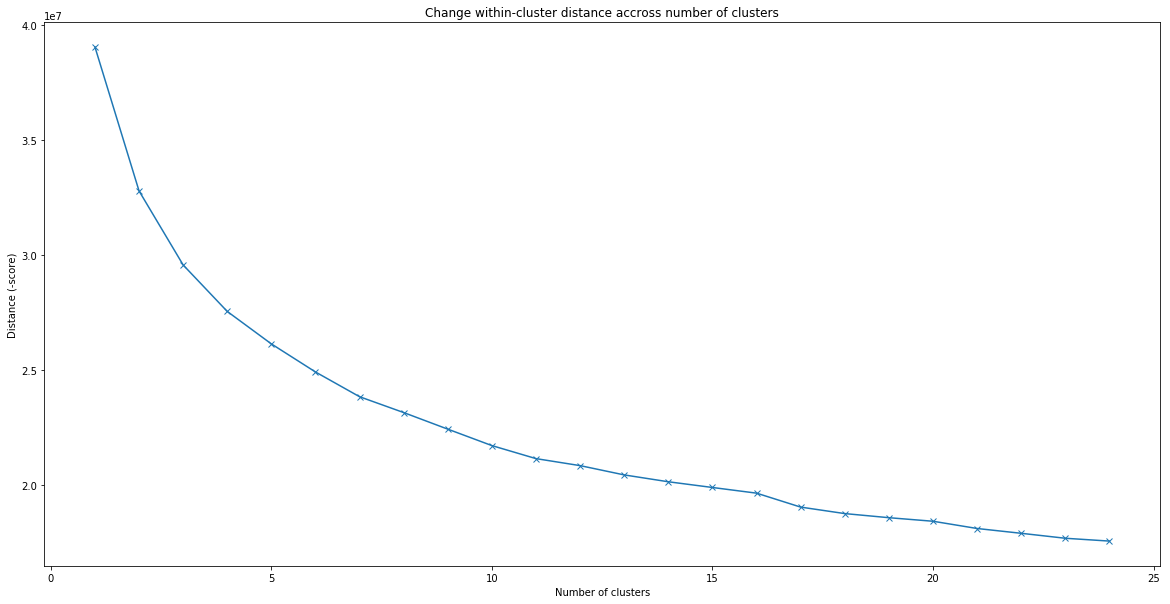

In [339]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize = (20,10))
plt.plot(number_of_clusters, distances_within_cluster, marker ='x')
plt.xlabel('Number of clusters')
plt.ylabel('Distance (-score)')
plt.title('Change within-cluster distance accross number of clusters')

In [340]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_10clusters = KMeans(n_clusters=10)
model = kmeans_10clusters.fit(azdias_n20)
demographics_clusters = model.predict(azdias_n20)

### Discussion 3.1: Apply Clustering to General Population


- I computed the score of kmeans-clusterings for different number of clusters ranging from 1 to 25. I assumed the negatives of the scores represent the average distance from each point to its assigned cluster's center. As these computations take a bit more time than usual, I stored the distances in a list called distance_stored as hard-coded values from my computations.
- I plotted the change of distance accross the number of clusters used for computation.
- We can see that after 10 clusters, the distance decreases less for each new cluster we use: It looks like the elbow in the curve. I chose to select a model with 10 clusters to predict clusters on the demographics dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [341]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
initial_len = len(customers)

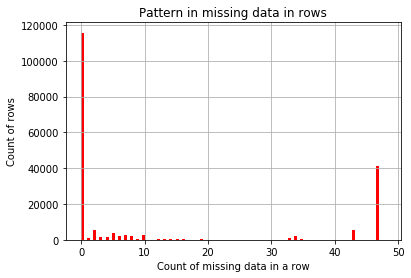

In [342]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean the dataset
customers_fc = clean_data(customers)
clean_len = len(customers_fc)
number_of_outlier_customers = initial_len-clean_len

In [343]:
# Replace Nan values
customers_cln = imputer.fit_transform(customers_fc)
customers_clean = pd.DataFrame(customers_cln, columns = customers_fc.columns)

In [344]:
# Standardize dataset relatively to the demographics
scaled = scaler.transform(customers_clean)
customers_proc = pd.DataFrame(scaled, columns = customers_clean.columns)

In [345]:
# Apply PCA with 20 components fitted on demographics
customers_n20 = pca_n20.transform(customers_proc)

In [346]:
# Use the model fitted on demographics to predict customer clusters
customers_clusters = model.predict(customers_n20)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [347]:
# We compute the proportion of individuals within our clusters in the general population.
# We take into account the rows that were missing many values and that we dropped in step 1.1.3.

tot_dem = len(azdias_n20) + number_of_outlier_rows
dem_df = pd.DataFrame(demographics_clusters,columns=['Cluster'])
dem_df = dem_df.reset_index().groupby('Cluster').count()/tot_dem*100
dem_df.columns = ['% of Population']

outlier_dem = pd.DataFrame(columns =['% of Population'])
outlier_dem.loc['Missing'] = 100- dem_df.sum()

# Demographics distribution with last cluster (column) being the dropped rows with a lot of missing values.
dem_dist = pd.concat([dem_df,outlier_dem], ignore_index=False)



# We compute the proportion of individuals within our clusters in the customer population.
# We take into account the rows that were missing many values and that we dropped in Step 3.2.

tot_cust = len(customers_n20) + number_of_outlier_customers
cust_df = pd.DataFrame(customers_clusters,columns=['Cluster'])
cust_df = cust_df.reset_index().groupby('Cluster').count()/tot_cust*100
cust_df.columns = ['% of Population']

outlier_cust = pd.DataFrame(columns =['% of Population'])
outlier_cust.loc['Missing'] = 100- cust_df.sum()

# Customers distribution with last cluster (column) being the dropped rows with a lot of missing values.
cust_dist = pd.concat([cust_df,outlier_cust], ignore_index=False)    

In [348]:
dem_dist

,% of Population
0,7.629982
1,14.009544
2,6.654691
3,6.859466
4,10.566964
5,9.887334
6,11.893571
7,9.961727
8,9.339771
9,0.734498


In [349]:
cust_dist

,% of Population
0,0.716403
1,13.893933
2,24.625363
3,1.308622
4,7.754680
5,13.875670
6,7.570492
7,1.338885
8,0.767015
9,0.711707


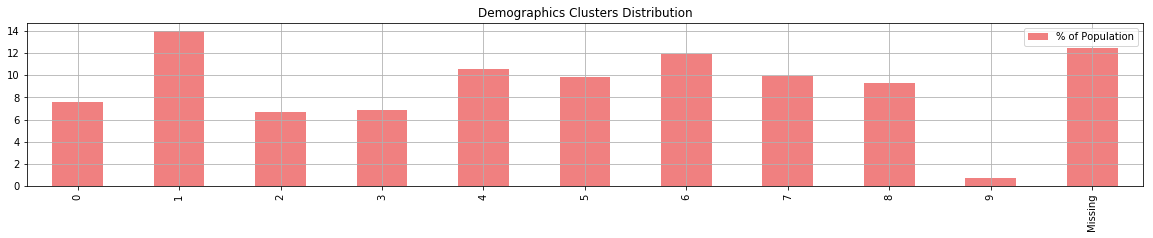

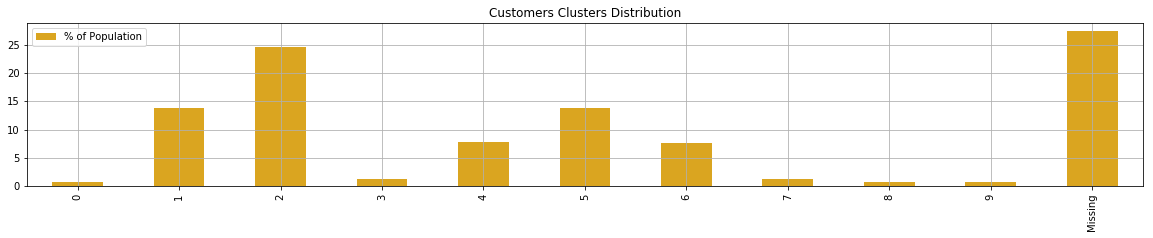

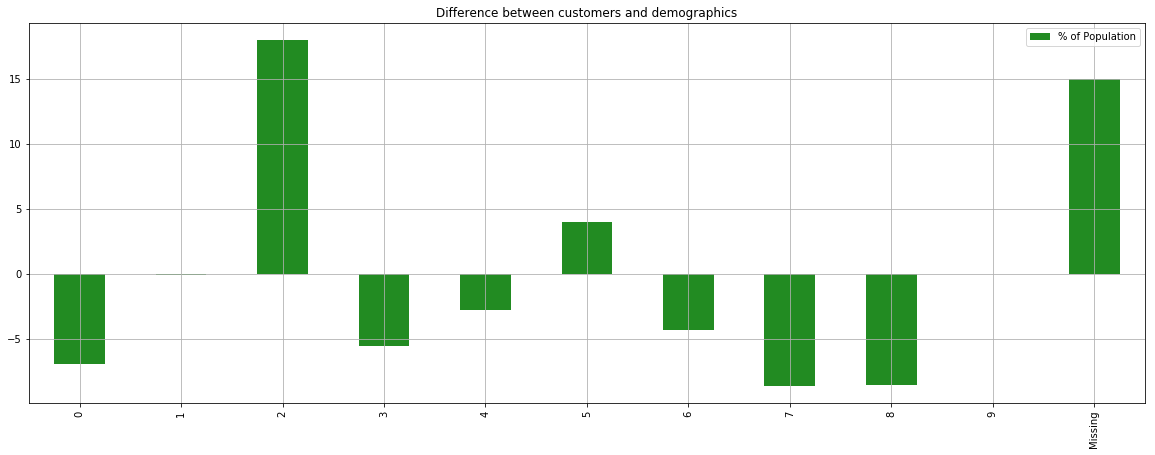

In [350]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig = dem_dist.plot(kind='bar', color='lightcoral', figsize = (20,3))
plt.title('Demographics Clusters Distribution')
plt.grid()
plt.show()

fig2 = cust_dist.plot(kind='bar', color='goldenrod', figsize = (20,3))
plt.title('Customers Clusters Distribution')
plt.grid()
plt.show()

fig3 = (cust_dist-dem_dist).plot(kind='bar', color='forestgreen', figsize = (20,7))
plt.title('Difference between customers and demographics')
plt.grid()
plt.show()


In [358]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_cluster2 = scaler.inverse_transform(pca_n20.inverse_transform(model.cluster_centers_[2]))

overrepresented_customer = pd.Series(data = centroid_cluster2, index = customers_clean.columns)
overrepresented_customer

ALTERSKATEGORIE_GROB        3.225100
ANREDE_KZ                   1.082475
FINANZ_MINIMALIST           4.782907
FINANZ_SPARER               1.603643
FINANZ_VORSORGER            4.250119
FINANZ_ANLEGER              1.472211
FINANZ_UNAUFFAELLIGER       2.186559
FINANZ_HAUSBAUER            1.990871
GREEN_AVANTGARDE            0.961843
HEALTH_TYP                  2.057371
RETOURTYP_BK_S              3.823554
SEMIO_SOZ                   5.312071
SEMIO_FAM                   4.790031
SEMIO_REL                   3.715982
SEMIO_MAT                   3.669265
SEMIO_VERT                  6.184472
SEMIO_LUST                  5.108405
SEMIO_ERL                   4.069621
SEMIO_KULT                  4.800844
SEMIO_RAT                   2.704167
SEMIO_KRIT                  3.244040
SEMIO_DOM                   3.363689
SEMIO_KAEM                  2.728881
SEMIO_PFLICHT               3.273158
SEMIO_TRADV                 3.175083
SOHO_KZ                    -0.000043
VERS_TYP                    1.520510
A

In [359]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_cluster7 = scaler.inverse_transform(pca_n20.inverse_transform(model.cluster_centers_[7]))

underrepresented_customer1 = pd.Series(data = centroid_cluster7, index = customers_clean.columns)
underrepresented_customer1

ALTERSKATEGORIE_GROB        1.833095
ANREDE_KZ                   1.978024
FINANZ_MINIMALIST           2.379316
FINANZ_SPARER               3.934314
FINANZ_VORSORGER            2.278975
FINANZ_ANLEGER              4.386264
FINANZ_UNAUFFAELLIGER       3.818077
FINANZ_HAUSBAUER            2.764378
GREEN_AVANTGARDE            0.194901
HEALTH_TYP                  2.338962
RETOURTYP_BK_S              2.437576
SEMIO_SOZ                   2.998669
SEMIO_FAM                   3.608048
SEMIO_REL                   4.994350
SEMIO_MAT                   4.712008
SEMIO_VERT                  2.575475
SEMIO_LUST                  3.039736
SEMIO_ERL                   4.455491
SEMIO_KULT                  3.916163
SEMIO_RAT                   5.930084
SEMIO_KRIT                  5.455118
SEMIO_DOM                   5.971442
SEMIO_KAEM                  5.619599
SEMIO_PFLICHT               5.878131
SEMIO_TRADV                 5.452051
SOHO_KZ                     0.000420
VERS_TYP                    1.410402
A

In [360]:
centroid_cluster8 = scaler.inverse_transform(pca_n20.inverse_transform(model.cluster_centers_[8]))

underrepresented_customer2 = pd.Series(data = centroid_cluster8, index = customers_clean.columns)
underrepresented_customer2

ALTERSKATEGORIE_GROB        1.692498
ANREDE_KZ                   2.002143
FINANZ_MINIMALIST           1.156799
FINANZ_SPARER               4.273253
FINANZ_VORSORGER            2.201327
FINANZ_ANLEGER              4.152607
FINANZ_UNAUFFAELLIGER       3.672489
FINANZ_HAUSBAUER            4.193978
GREEN_AVANTGARDE            0.048589
HEALTH_TYP                  2.335391
RETOURTYP_BK_S              2.731044
SEMIO_SOZ                   3.366238
SEMIO_FAM                   3.919409
SEMIO_REL                   5.287012
SEMIO_MAT                   4.894088
SEMIO_VERT                  2.256227
SEMIO_LUST                  2.907113
SEMIO_ERL                   4.320202
SEMIO_KULT                  4.114558
SEMIO_RAT                   6.091031
SEMIO_KRIT                  5.559531
SEMIO_DOM                   6.178215
SEMIO_KAEM                  6.146797
SEMIO_PFLICHT               6.175774
SEMIO_TRADV                 5.489911
SOHO_KZ                     0.000364
VERS_TYP                    1.497597
A

### Discussion 3.3: Compare Customer Data to Demographics Data


- I computed the proportion of individuals within our clusters in the general population.  I took into account the rows that were missing many values and that we dropped in step 1.1.3..
- I computed the proportion of individuals within our clusters in the customer population. I took into account the rows that were missing many values and that we dropped in Step 3.2.
- I plotted the distributions with the last column "missing" representing the data points that we dropped and did not used for unsupervised learning.
- The difference plot between customers and general demographics in each cluster highlight the target clusters for customers and the clusters where few customers are represented.
- By inverse-transforming those clusters, I looked at the features for the respective centroid of overrepresented clusters: in our case: cluster 2. Following can be said about the segments of population that are relatively popular with the mail-order company:
-> Financial saver
-> Financial investor
-> Mid-high age (46+)
-> Rather male persons
-> High income
-> Living in West-Germany
-> Living in a region with little mobility.

- Similarly, I looked at the features for the respective centroid of underrepresented clusters: in our case: cluster 7 and cluster 8. Following can be said about the segments of population that are relatively unpopular with the mail-order company:
-> Poor financial saver
-> Poor financial investor
-> Lower age (-45)
-> Rather female persons
-> Low to very low income
-> Living in a region with high mobility


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.